# Build Project #2: 

Evaluating whether or not "treatment" of mental health is predictable using a survey dataset on Mental Health in the Tech Workplace in 2014.

[Link to the Kaggle Dataset](https://www.kaggle.com/osmi/mental-health-in-tech-survey)



In [87]:
# importing of the relevant libraries: 
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np 
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from xgboost import XGBClassifier
import shap

plt.rcParams['figure.dpi'] = 100

## Preliminary visualization of the data to understand features. 

The goal here is to take a look at the dataset and understand key features, and how the data can be manipulated. 

Going into the dataset I'm aware that the value I'm trying to predict is whether or not treatment was sought. The responses to this variable is either a yes or no.

In [88]:
# quickly visualizing our dataset in a pandas dataframe. 
build_d = pd.read_csv('datasets_311_673_survey.csv')
build_d.sample(8)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
285,2014-08-27 14:11:46,27,Male,United Kingdom,NaN,No,Yes,Yes,Sometimes,6-25,...,Somewhat easy,Maybe,Maybe,Yes,Yes,Yes,Yes,Yes,No,Hi Ed it's Paul Dragoonis. I have Aspergers/Hi...
308,2014-08-27 14:22:43,25,Male,United States,OR,No,No,No,NaN,26-100,...,Don't know,No,No,Some of them,Yes,No,No,Don't know,No,NaN
1080,2014-08-29 15:59:55,25,Male,United States,UT,No,Yes,Yes,Often,1-5,...,Very easy,Maybe,No,Yes,Yes,No,Maybe,No,No,NaN
462,2014-08-27 16:01:52,28,Make,United States,UT,No,No,No,Sometimes,6-25,...,Somewhat easy,Yes,Maybe,Some of them,No,No,No,Don't know,No,NaN
912,2014-08-28 18:21:58,24,Female,United Kingdom,NaN,No,Yes,Yes,Often,6-25,...,Very easy,No,No,Yes,Yes,No,No,Don't know,No,NaN
605,2014-08-27 23:09:46,32,Male,United States,MI,No,No,No,Sometimes,100-500,...,Don't know,Maybe,Maybe,Some of them,Some of them,No,No,No,No,NaN
352,2014-08-27 14:51:29,30,Male,United Kingdom,NaN,No,No,No,Never,6-25,...,Very easy,No,No,Some of them,Yes,No,Maybe,Yes,No,A co-worker recently had mental health issues ...
981,2014-08-29 08:59:08,37,Female,Canada,NaN,Yes,Yes,Yes,Rarely,1-5,...,Somewhat easy,Yes,Maybe,Some of them,Some of them,Maybe,Maybe,Don't know,Yes,NaN


In [89]:
# looking at the shape and the number of rows in the dataframe, as one of the key requirements is to have a 
# dataset that: isn't too small --> "As a rough rule, your dataset should generally have 500+ observations (rows)"
build_d.shape, build_d.columns

((1259, 27),
 Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
        'family_history', 'treatment', 'work_interfere', 'no_employees',
        'remote_work', 'tech_company', 'benefits', 'care_options',
        'wellness_program', 'seek_help', 'anonymity', 'leave',
        'mental_health_consequence', 'phys_health_consequence', 'coworkers',
        'supervisor', 'mental_health_interview', 'phys_health_interview',
        'mental_vs_physical', 'obs_consequence', 'comments'],
       dtype='object'))

In [90]:
# observing the key variable or column --> "treatment"
build_d['treatment'].describe()

count     1259
unique       2
top        Yes
freq       637
Name: treatment, dtype: object

In [91]:
# utilzing the pandas profiling feature to quickly assess the viability of this dataset for modeling. 
from pandas_profiling import ProfileReport
profile = ProfileReport(build_d, minimal=True).to_notebook_iframe()
profile

### Results of the Visualization: 

As we can see there are numerous columns with missing data, and numerous columns that have high-cardinality. 

## Cleanup of the dataset: Priming for modeling. 

The goal here to cleanup missing values and attempt to corral high-cardinality features and reduce thier cardinality. 

In [92]:
# visualizing the degree of features that are high in cardinality --> this can be done looking at the profiling report 
# and manually writing down values but that is pointless. 
cardinality = build_d.select_dtypes(exclude='number').nunique()
high_cardinality_feat = cardinality[cardinality > 40].index.tolist()
high_cardinality_feat

['Timestamp', 'Gender', 'Country', 'state', 'comments']

In [93]:
# exluding time stamp and gender. 
high_cardinality_feat.remove('Gender')
high_cardinality_feat

['Timestamp', 'Country', 'state', 'comments']

In [94]:
# before attempting to clean up gender, its critical to assess its present values
build_d['Gender'].describe()

count     1259
unique      49
top       Male
freq       615
Name: Gender, dtype: object

In [95]:
build_d['Gender'].value_counts(normalize=True)


Male                                              0.488483
male                                              0.163622
Female                                            0.096108
M                                                 0.092137
female                                            0.049245
F                                                 0.030183
m                                                 0.027006
f                                                 0.011914
Make                                              0.003177
Male                                              0.002383
Woman                                             0.002383
Man                                               0.001589
Female (trans)                                    0.001589
Female                                            0.001589
Cis Male                                          0.001589
femail                                            0.000794
p                                                 0.0007

In [96]:
# It seems like for the sake of reducing cardinality gender can be cleaned up a little: 
# editorial note, I'm of the opinion that gender is not a trinary or binary, but the above responses some of them 
# are clearly meme'd on.

df_clean = build_d.copy()
df_clean['Gender'] = df_clean['Gender'].str.lower()
male = df_clean['Gender'].str.contains('male')
female = df_clean['Gender'].str.contains('female')
woman = df_clean['Gender'].str.contains('woman')
man = df_clean['Gender'].str.contains('man')
m = df_clean['Gender'].str.contains('m')
f = df_clean['Gender'].str.contains('f')
df_clean.loc[male, 'Gender'] = 'Male'
df_clean.loc[man, 'Gender'] = 'Male'
df_clean.loc[m, 'Gender'] = 'Male'
df_clean.loc[f, 'Gender'] = 'Female'
df_clean.loc[female, 'Gender'] = 'Female'
df_clean.loc[woman, 'Gender'] = 'Female'
df_clean.loc[~male & ~man & ~m & ~f & ~female & ~woman, 'Gender'] = 'Other'

In [97]:
# these observations are roughly in line with traditional statistics done in this field. 
# for a quick infographic: https://www.themuse.com/advice/the-latest-stats-on-women-in-tech
df_clean['Gender'].value_counts(normalize=True)

Male      0.789515
Female    0.200159
Other     0.010326
Name: Gender, dtype: float64

In [98]:
# merging the cleaning with the original dataset
build_d['Gender'] = df_clean['Gender']

In [99]:
# work interfere is an intersting categorey that contains missing values,
# without it the model will simply not run. 
# to jankly work around this I fill in missing values with a "missing"
build_d['work_interfere'] = build_d['work_interfere'].fillna('missing')
build_d['work_interfere'].value_counts(normalize=True)

Sometimes    0.369341
missing      0.209690
Never        0.169182
Rarely       0.137411
Often        0.114376
Name: work_interfere, dtype: float64

In [100]:
# age is another categorey that got meme'd on as you can see some value counts are simply put to 
# test the patience of the person cleaning the dataset up. 
build_d['Age'].value_counts(normalize=True)

 29             0.067514
 32             0.065131
 26             0.059571
 27             0.056394
 33             0.055600
 28             0.054011
 31             0.053217
 34             0.051628
 30             0.050040
 25             0.048451
 35             0.043685
 23             0.040508
 24             0.036537
 37             0.034154
 38             0.030977
 36             0.029388
 39             0.026211
 40             0.026211
 43             0.022240
 41             0.016680
 22             0.016680
 42             0.015886
 21             0.012708
 45             0.009531
 46             0.009531
 44             0.008737
 19             0.007149
 18             0.005560
 20             0.004766
 48             0.004766
 50             0.004766
 51             0.003971
 56             0.003177
 49             0.003177
 57             0.002383
 54             0.002383
 55             0.002383
 47             0.001589
 60             0.001589
 11             0.000794


In [101]:
# cutting the bottom 0.5% of ages and the top 99.5% of ages as those are clearly outliers. 
build_d = build_d[(build_d['Age'] >= np.percentile(build_d['Age'], 0.5)) & 
        (build_d['Age'] <= np.percentile(build_d['Age'], 99.5))]

In [102]:
# replacing NaN values again with "0", as a missing condition. 
build_d['self_employed'] = build_d['self_employed'].replace(np.nan, 0)
build_d['self_employed'].value_counts(normalize=True)

No     0.873296
Yes    0.112269
0      0.014435
Name: self_employed, dtype: float64

## Dataset is primed for modeling: 

First we will evaluate a "guess" or baseline based on normalized value counts.

Then we will test-train split the data. 

Then we will Employ: 

    - Decision Tree Model
    - Logistic Regression Model. 

In [103]:
# by guessing: 
build_d['treatment'].value_counts(normalize=True)

Yes    0.505213
No     0.494787
Name: treatment, dtype: float64

In [104]:
build_d = build_d.drop(columns = high_cardinality_feat)
build_d.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,0,No,Yes,Often,6-25,No,Yes,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,Male,0,No,No,Rarely,More than 1000,No,No,Don't know,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,0,No,No,Rarely,6-25,No,Yes,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,0,Yes,Yes,Often,26-100,No,Yes,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,0,No,No,Never,100-500,Yes,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [105]:
# saving the treatment category: then dropping it to avoid data leakage.  
y = build_d['treatment']
build_d = build_d.drop(columns = 'treatment')
X_train, X_test, y_train, y_test = train_test_split(build_d, y, test_size=0.2)

In [106]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((997, 22), (250, 22), (997,), (250,))

### Editorial Note: On why validation accuracy is "score": 

```
For classification problems:

As a rough rule of thumb, if majority class frequency is >= 50% and < 70% then you can just use accuracy if you want. 

Outside that range, accuracy could be misleading. 

```
Was said in lecture notes. And our majority class is above the 50% threshold for cutoff. 

In [107]:
# evaluating a validation accuracy based on a simple decision tree model: 

pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=3, random_state = 40)
)
pipeline.fit(X_train, y_train)
print(f'Validation accuracy: {pipeline.score(X_train, y_train)}')

Validation accuracy: 0.8375125376128385


In [108]:
# evaluating a validation accuracy based on a simple logistic regression model: 

pipeline2 = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    LogisticRegression()
)
pipeline2.fit(X_train, y_train)
print(f'Validation accuracy: {pipeline2.score(X_train, y_train)}')

Validation accuracy: 0.7733199598796389


In [109]:
# evaluating a gradient boosted model: 

pipeline3 = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline3.fit(X_train, y_train)

y_pred = pipeline3.predict(X_test)
print(f'Validation accuracy: {accuracy_score(y_test, y_pred)}')

Validation accuracy: 0.768


## Visualizations and Explanation of Models: 

Here we plot some visualizations in attempt to understand what our model is telling us regarding which features are important for determining and prediciting whether or not a person sought care. 

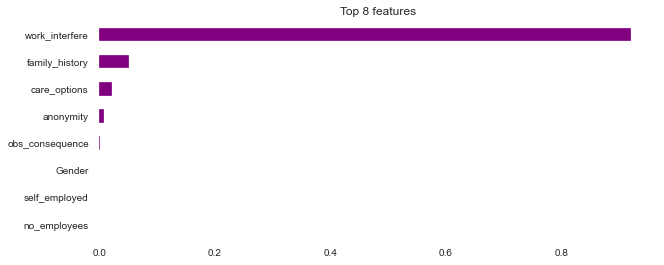

In [110]:
# Get feature importances
rf = pipeline.named_steps['decisiontreeclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 8
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='purple');

In [111]:
def plot_stack(column_1, column_2):
 plot_stck=pd.crosstab(index=column_1, columns=column_2)
 plot_stck.plot(kind='bar', figsize=(8,8), stacked=False)
 return

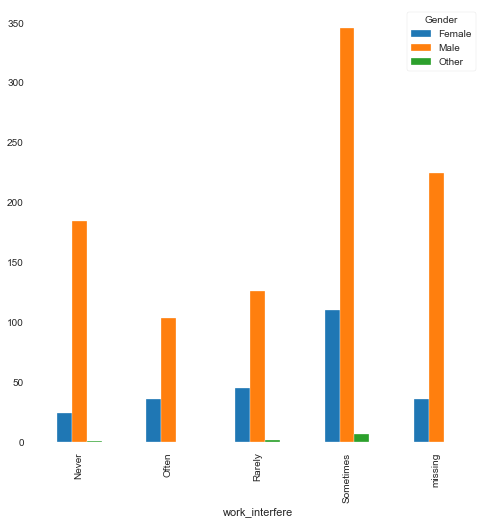

In [112]:
plot_stack(build_d['work_interfere'], build_d['Gender'])

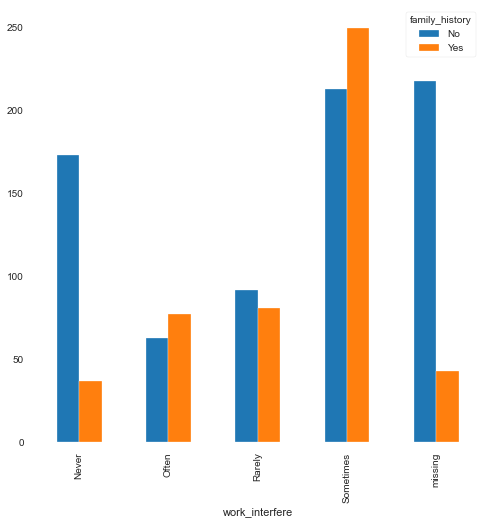

In [113]:
plot_stack(build_d['work_interfere'], build_d['family_history'])

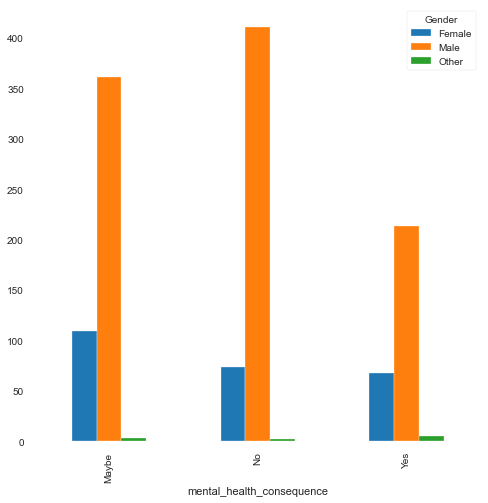

In [114]:
plot_stack(build_d['mental_health_consequence'], build_d['Gender'])

In [115]:
transformers = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)
X_train_transformed = transformers.fit_transform(X_train)
X_test_transformed = transformers.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    random_state=42
)

permuter.fit(X_test_transformed, y_test)

feature_names = X_test.columns.tolist()

eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1928 ± 0.0305,work_interfere
0.0648 ± 0.0192,family_history
0.0224 ± 0.0120,leave
0.0200 ± 0.0272,benefits
0.0192 ± 0.0138,mental_vs_physical
0.0168 ± 0.0185,care_options
0.0144 ± 0.0120,coworkers
0.0136 ± 0.0082,remote_work
0.0088 ± 0.0155,seek_help
0.0080 ± 0.0196,phys_health_interview


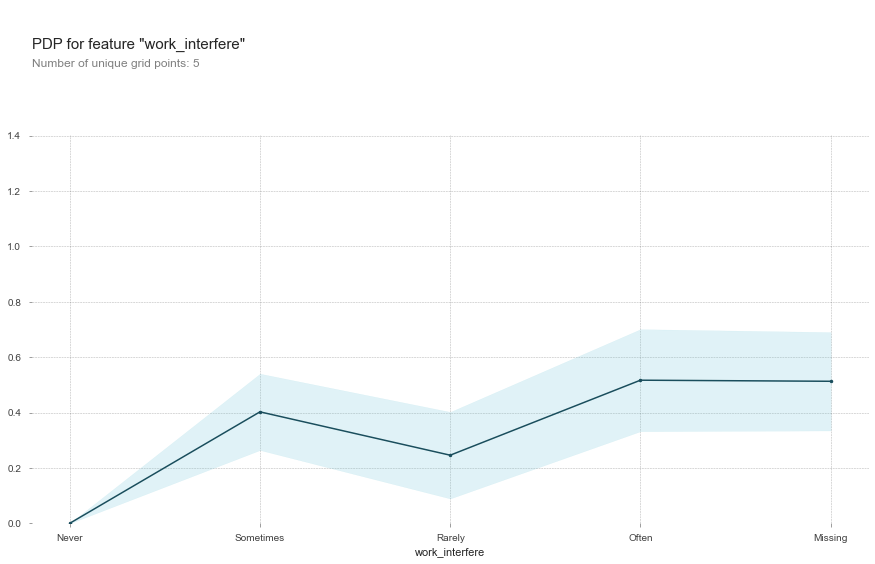

In [117]:
features = X_train.columns
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y_train)

# Using Pdpbox
feature = 'work_interfere'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);
plt.xticks([1, 2, 3, 4, 5], ['Never', 'Sometimes', 'Rarely', 'Often', 'Missing']);

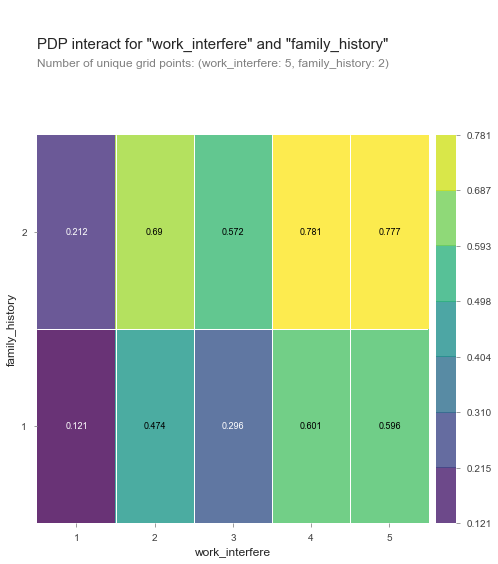

In [118]:
features = ['work_interfere', 'family_history']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [119]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

eval_set = [(X_train_processed, y_train), 
            (X_test_processed, y_test)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

row = X_test.iloc[[25]]

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

[0]	validation_0-auc:0.93268	validation_1-auc:0.84261
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.94075	validation_1-auc:0.85172
[2]	validation_0-auc:0.95078	validation_1-auc:0.84999
[3]	validation_0-auc:0.95451	validation_1-auc:0.85544
[4]	validation_0-auc:0.95858	validation_1-auc:0.85284
[5]	validation_0-auc:0.96445	validation_1-auc:0.85317
[6]	validation_0-auc:0.96827	validation_1-auc:0.85124
[7]	validation_0-auc:0.97244	validation_1-auc:0.85644
[8]	validation_0-auc:0.97339	validation_1-auc:0.85381
[9]	validation_0-auc:0.97618	validation_1-auc:0.85272
[10]	validation_0-auc:0.97790	validation_1-auc:0.85377
[11]	validation_0-auc:0.98109	validation_1-auc:0.85156
[12]	validation_0-auc:0.98244	validation_1-auc:0.85243
[13]	validation_0-auc:0.98436	validation_1-auc:0.84989
[14]	validation_0-auc:0.98464	validation_1-auc:0.84669
[15]	validation_0-auc:0.9870